In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2022-12-12 10:15:05.759363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 10:15:06.596992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-12 10:15:06.597312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-12 10:15:06.597318: W tensorflow/compiler/tf

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [4]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head()


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN


In [5]:
def reduce_shape(data):
    # shape now = (181, 217, 181)
    reduced_data = data[::4, ::4, ::4]
    # on prend juste 1 pixel sur 2
    return reduced_data

# problème : il faut qu'on ait le même format de données pourque ça fonctionne 

In [6]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            reduced_shape_data = reduce_shape(img_n_mmni)
        
            X_data.append(reduced_shape_data)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)
          
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [7]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(419, 46, 55, 46)
419


In [8]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  335
Data splited, length of test data is:  84


In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization


model1 = Sequential()
# Couches de convolution + MaxPooling
model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(46,55,46,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization(center=True, scale=True))
model1.add(Dropout(0.3))
model1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization(center=True, scale=True))
model1.add(Dropout(0.3))
model1.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization(center=True, scale=True))
model1.add(Dropout(0.3))
# Couches de classification
model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model1.summary()


2022-12-12 10:16:15.226365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 10:16:15.245931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 10:16:15.246063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 10:16:15.247986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 44, 53, 44, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 22, 26, 22, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 22, 26, 22, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 22, 26, 22, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 24, 20, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 12, 10, 64)   0

In [11]:
# ajout d'un early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

history = model1.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test),callbacks=[callback],batch_size=2)

Epoch 1/80


2022-12-12 10:16:17.569852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-12 10:16:18.285643: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 10:16:19.075127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


168/168 [==============================] - 5s 13ms/step - loss: 1.4236 - accuracy: 0.5224 - val_loss: 0.6240 - val_accuracy: 0.6905
Epoch 2/80
168/168 [==============================] - 2s 11ms/step - loss: 0.8636 - accuracy: 0.5731 - val_loss: 1.6702 - val_accuracy: 0.6071
Epoch 3/80
168/168 [==============================] - 2s 11ms/step - loss: 1.2384 - accuracy: 0.5612 - val_loss: 0.6425 - val_accuracy: 0.6667
Epoch 4/80
168/168 [==============================] - 2s 11ms/step - loss: 0.6560 - accuracy: 0.6627 - val_loss: 0.6070 - val_accuracy: 0.6310
Epoch 5/80
168/168 [==============================] - 2s 11ms/step - loss: 0.5066 - accuracy: 0.7612 - val_loss: 0.5482 - val_accuracy: 0.7381
Epoch 6/80
168/168 [==============================] - 2s 11ms/step - loss: 0.4064 - accuracy: 0.8090 - val_loss: 1.9359 - val_accuracy: 0.4048
Epoch 7/80
168/168 [==============================] - 2s 11ms/step - loss: 0.4379 - accuracy: 0.8209 - val_loss: 0.6997 - val_accuracy: 0.7381
Epoch 8/80

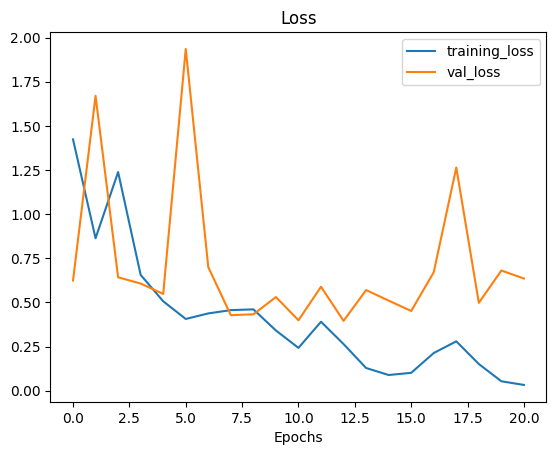

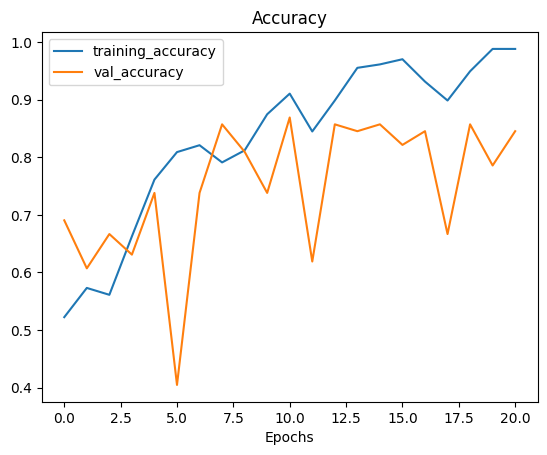

In [12]:
def plot_loss_curves(history):
    
      
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

# Training with whole AD and CN data

In [15]:
model2 = Sequential()
# Couches de convolution + MaxPooling
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(46,55,46,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
# Couches de classification
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model2.summary()

    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 44, 53, 44, 32)    896       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 22, 26, 22, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 22, 26, 22, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 22, 26, 22, 32)    0         
                                                                 
 conv3d_7 (Conv3D)           (None, 20, 24, 20, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 12, 10, 64)  

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)

history2 = model2.fit(X_data, y_data, epochs=30)

Epoch 1/20
14/14 [==============================] - 3s 104ms/step - loss: 1.4809 - accuracy: 0.5298
Epoch 2/20
14/14 [==============================] - 1s 88ms/step - loss: 0.6342 - accuracy: 0.6539
Epoch 3/20
14/14 [==============================] - 1s 88ms/step - loss: 0.5890 - accuracy: 0.6897
Epoch 4/20
14/14 [==============================] - 1s 88ms/step - loss: 0.6841 - accuracy: 0.6277
Epoch 5/20
14/14 [==============================] - 1s 88ms/step - loss: 0.5337 - accuracy: 0.7327
Epoch 6/20
14/14 [==============================] - 1s 88ms/step - loss: 0.5679 - accuracy: 0.7208
Epoch 7/20
14/14 [==============================] - 1s 87ms/step - loss: 0.5266 - accuracy: 0.7566
Epoch 8/20
14/14 [==============================] - 1s 87ms/step - loss: 0.3819 - accuracy: 0.8186
Epoch 9/20
14/14 [==============================] - 1s 88ms/step - loss: 0.3531 - accuracy: 0.8258
Epoch 10/20
14/14 [==============================] - 1s 88ms/step - loss: 0.3475 - accuracy: 0.8353
Epoch 11

# Testing with pMCI et sMCI data 

- pMCI ~ AD ==1
- sMCI ~ CN ==0

In [17]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data


In [18]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [19]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data_MCI(path)
y_data.head()


,Rooster ID,Group,Conversion
Subject ID,,,
002_S_0729,729,MCI,3
002_S_0782,782,MCI,4
002_S_0954,954,MCI,3
002_S_1070,1070,MCI,3
002_S_1155,1155,MCI,4


# Data preparation & splitting 

In [20]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            reduced_shape_data = reduce_shape(img_n_mmni)
        
            X_data.append(reduced_shape_data)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0) 
          
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data




In [21]:
X_data, Y_data = Data_preparation_MCI(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(300, 46, 55, 46)
300


In [34]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

## Prédiction 

In [35]:
ypred_raw_model1 = model1.predict(X_data)
ypred_raw_model2 = model2.predict(X_data)

10/10 [==============================] - 0s 30ms/step


In [36]:
ypred_model1 = np.where(ypred_raw_model1 > 0.5, 1, 0)
ypred_model2 = np.where(ypred_raw_model2 > 0.5, 1, 0)

In [37]:
from sklearn.metrics import accuracy_score

acc_model1 = accuracy_score(ypred_model1, y_data)
acc_model2 = accuracy_score(ypred_model2, y_data)

print('accuracy on MCI data based on CN and AD training with model 1: {} '.format(acc_model1))
print('accuracy on MCI data based on CN and AD training with model 2: {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training with model 1: 0.6266666666666667 
accuracy on MCI data based on CN and AD training with model 2: 0.61 


[[103  26]
 [ 86  85]]


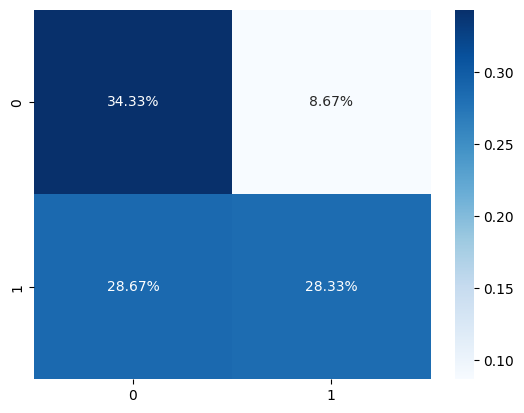

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

names = ['sMCI','pMCI']

cf_matrix = confusion_matrix(y_data, ypred_model1)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

- pMCI ~ AD ==1
- sMCI ~ CN ==0